<a href="https://colab.research.google.com/github/gagansingh23/DS-Unit-2-Applied-Modeling/blob/master/Gagan_Singh_DS11_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍕

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [0]:
#Installers
import category_encoders as ce
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from pdpbox.pdp import pdp_isolate, pdp_plot
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_interact, pdp_interact_plot

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Confusion Matrix
- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [60]:
#Feature Selection
train.describe(exclude='number').nunique()


DBA Name           4
AKA Name           4
Facility Type      4
Risk               4
Address            4
City               4
State              3
Inspection Date    4
Inspection Type    4
Violations         4
Location           4
dtype: int64

In [61]:
train.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Fail'],
      dtype='object')

In [62]:
train.Fail.value_counts(normalize=True)

0    0.74139
1    0.25861
Name: Fail, dtype: float64

In [64]:
train_pratice = train[train['Violations'].str.contains("HAZARD", na=False)]
train_pratice.Fail.value_counts(normalize=True)

1    0.941274
0    0.058726
Name: Fail, dtype: float64

In [111]:
target = 'Fail'
train_features = train.drop(columns=[target])

cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 40].index.tolist()
numerical_features = train_features.select_dtypes(include='number').columns.tolist()
categorical_features

['Risk', 'City', 'State', 'Inspection Type']

In [0]:
features = categorical_features + numerical_features

In [0]:
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[features]

In [0]:
#One Hot Encode all categorical variables with low cardinality
encoder = ce.OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [118]:
#Perform a three way split
train, val = train_test_split(train, train_size=0.90, test_size=0.10, 
                              stratify=train['Fail'], random_state=42)


train.shape, val.shape, test.shape

((10169, 17), (1130, 17), (1550, 17))

In [119]:
#Fit The Model 
model = XGBClassifier(n_estimators=100, n_jobs=-1)

model.fit(X_train_encoded, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [120]:
#prediction on train set
y_pred = model.predict(X_val_encoded)


roc_auc_score(y_val, y_pred)

0.5394183260348673

In [122]:
#Since its classifier, we need to use predicted probailities not discrete. 
y_pred_proba = model.predict_proba(X_val_encoded)[:,-1]
print('Test ROC Score', roc_auc_score(y_val, y_pred_proba))

Test ROC Score 0.7166206725605222


## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

**Partial Dependance Plot, 1 feature isolation**

In [128]:
features

['Risk',
 'City',
 'State',
 'Inspection Type',
 'Inspection ID',
 'License #',
 'Zip',
 'Latitude',
 'Longitude']

In [145]:
target = 'Fail'
features = train.columns.drop([target])

X = train[features]
y = train[target]

encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


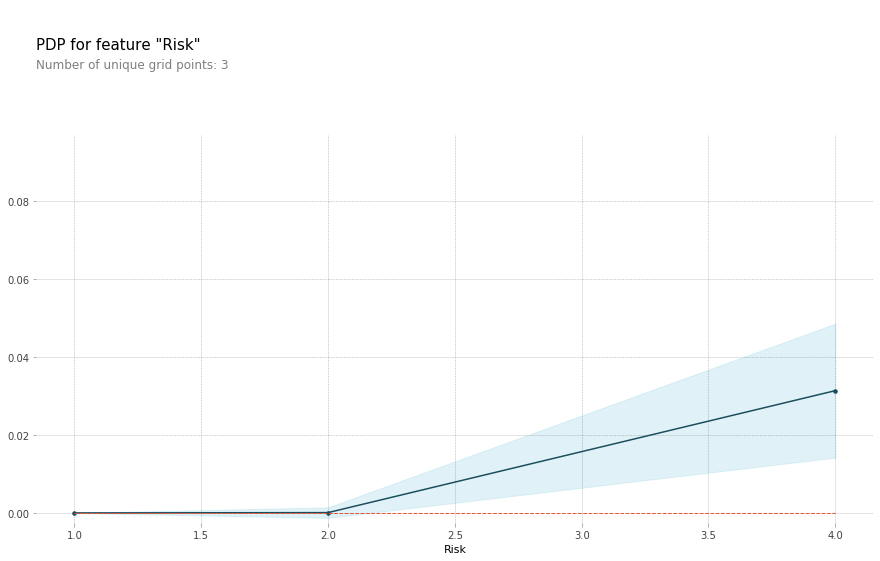

In [147]:
from pdpbox import pdp
feature = 'Risk'

pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features,
                           feature=feature)

pdp.pdp_plot(pdp_dist, feature);

**Partial Dependance Plot, 2 Feature Interaction**


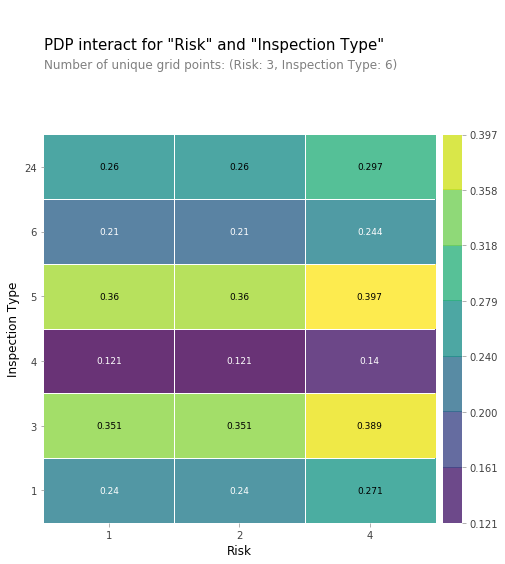

In [152]:
features = ['Risk', 'Inspection Type']

interactions = pdp_interact(
    model=model,
    dataset=X_encoded,
    model_features=X_encoded.columns,
    features=features
)
pdp_interact_plot(interactions, plot_type='grid', feature_names=features);